# Penalized Linear Regression for Climate Temperature Prediction

This notebook implements penalized linear regression models (Ridge, Lasso, and ElasticNet) to predict average temperature based on climate-related features.

## Overview
- **Goal**: Predict `avg_temperature` using climate variables
- **Models**: Ridge, Lasso, and ElasticNet regression
- **Approach**: Use cross-validation with pipelines to tune hyperparameters while avoiding data leakage
- **Metrics**: R² (coefficient of determination), MSE (Mean Squared Error), RMSE, MAE

## 1. Setup and Imports


In [87]:
# Core libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import os

# Scikit-learn: preprocessing, models, and evaluation
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.model_selection import cross_val_score, GridSearchCV, KFold, cross_val_predict
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Settings
import warnings
warnings.filterwarnings('ignore')
np.random.seed(42)

# Create output directory for penalized regression results
OUTPUT_DIR = '../output/penalizedlinreg-outputs'
os.makedirs(OUTPUT_DIR, exist_ok=True)


## 2. Load Training Data

We load only the training data for model development. The test set is reserved for final evaluation in a separate notebook.


In [88]:
# Load training data
X_train = pd.read_csv('../data/train_set_X.csv')
y_train = pd.read_csv('../data/train_set_y.csv').squeeze()  # Convert to Series

print(f"Training set size: {len(X_train)} samples")
print(f"\nFeatures ({X_train.shape[1]}):")
print(X_train.columns.tolist())
print(f"\nTarget: {y_train.name}")


Training set size: 800 samples

Features (7):
['co2_emissions', 'sea_level', 'rainfall', 'population', 'renewable_energy_pct', 'extreme_weather_events', 'forest_area_pct']

Target: avg_temperature




### Models We'll Compare:
1. **Ridge Regression (L2)**: Shrinks coefficients but keeps all features
2. **Lasso Regression (L1)**: Can shrink coefficients to exactly zero (feature selection)
3. **ElasticNet**: Combines L1 and L2 penalties



In [89]:
# Define cross-validation strategy
# Using 5-fold CV with shuffling for robust evaluation
cv = KFold(n_splits=5, shuffle=True, random_state=42)

print("Cross-validation strategy: 5-fold CV with shuffling")
print("Random state: 42 (for reproducibility)")


Cross-validation strategy: 5-fold CV with shuffling
Random state: 42 (for reproducibility)


## 4. Ridge Regression (L2 Penalty)


In [90]:
# Create Ridge pipeline with StandardScaler
ridge_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('ridge', Ridge(random_state=42))
])

# Define hyperparameter grid
# Testing a wide range of alpha values (log scale)
ridge_param_grid = {
    'ridge__alpha': [0.001, 0.01, 0.1, 1, 10, 100, 1000]
}

# Perform GridSearchCV
ridge_grid_search = GridSearchCV(
    ridge_pipeline,
    ridge_param_grid,
    cv=cv,
    scoring='r2',  # R² score (higher is better)
    return_train_score=True,
    n_jobs=-1
)

# Fit the grid search
ridge_grid_search.fit(X_train, y_train)

print("Ridge Regression - Grid Search Complete")
print(f"Best alpha: {ridge_grid_search.best_params_['ridge__alpha']}")
print(f"Best CV R²: {ridge_grid_search.best_score_:.4f}")


Ridge Regression - Grid Search Complete
Best alpha: 1000
Best CV R²: -0.0169


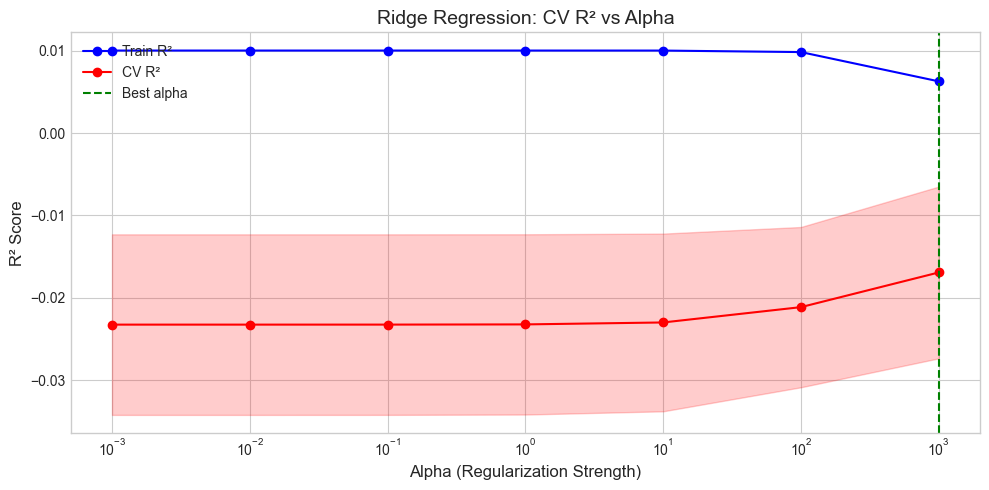

Figure saved to ../output/penalizedlinreg-outputs/ridge_cv_results.png


In [91]:
# Visualize Ridge CV results
ridge_results = pd.DataFrame(ridge_grid_search.cv_results_)

fig, ax = plt.subplots(figsize=(10, 5))

alphas = ridge_param_grid['ridge__alpha']
train_scores = ridge_results['mean_train_score']
test_scores = ridge_results['mean_test_score']
test_std = ridge_results['std_test_score']

ax.semilogx(alphas, train_scores, 'o-', label='Train R²', color='blue')
ax.semilogx(alphas, test_scores, 'o-', label='CV R²', color='red')
ax.fill_between(alphas, test_scores - test_std, test_scores + test_std, alpha=0.2, color='red')

ax.axvline(ridge_grid_search.best_params_['ridge__alpha'], linestyle='--', color='green', label='Best alpha')
ax.set_xlabel('Alpha (Regularization Strength)', fontsize=12)
ax.set_ylabel('R² Score', fontsize=12)
ax.set_title('Ridge Regression: CV R² vs Alpha', fontsize=14)
ax.legend()
plt.tight_layout()
plt.savefig(f'{OUTPUT_DIR}/ridge_cv_results.png', dpi=150)
plt.show()

print(f"Figure saved to {OUTPUT_DIR}/ridge_cv_results.png")


## 5. Lasso Regression (L1 Penalty)

In [92]:
# Create Lasso pipeline
lasso_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('lasso', Lasso(random_state=42, max_iter=10000))
])

# Define hyperparameter grid
lasso_param_grid = {
    'lasso__alpha': [0.001, 0.01, 0.1, 1, 10, 100, 1000]
}

# Perform GridSearchCV
lasso_grid_search = GridSearchCV(
    lasso_pipeline,
    lasso_param_grid,
    cv=cv,
    scoring='r2',  # R² score (higher is better)
    return_train_score=True,
    n_jobs=-1
)

# Fit the grid search
lasso_grid_search.fit(X_train, y_train)

print("Lasso Regression - Grid Search Complete")
print(f"Best alpha: {lasso_grid_search.best_params_['lasso__alpha']}")
print(f"Best CV R²: {lasso_grid_search.best_score_:.4f}")


Lasso Regression - Grid Search Complete
Best alpha: 1
Best CV R²: -0.0172


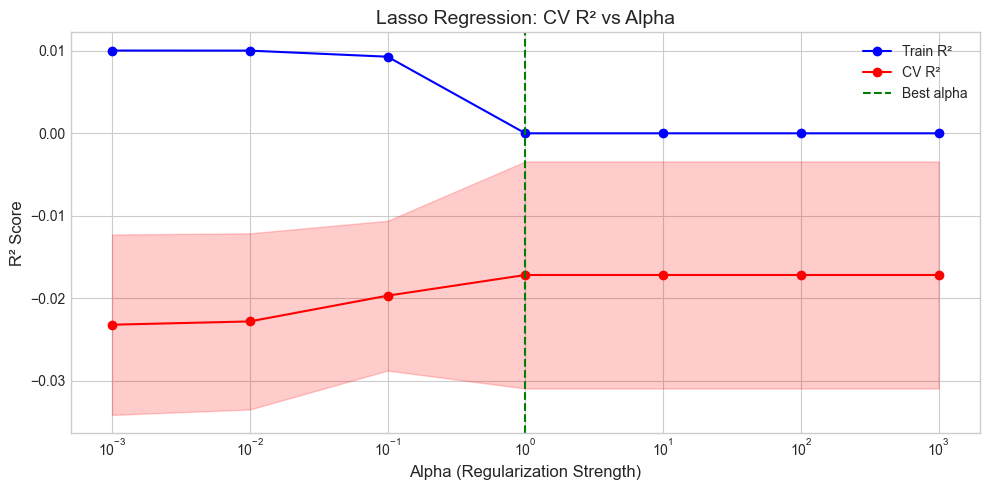

Figure saved to ../output/penalizedlinreg-outputs/lasso_cv_results.png


In [79]:
# Visualize Lasso CV results
lasso_results = pd.DataFrame(lasso_grid_search.cv_results_)

fig, ax = plt.subplots(figsize=(10, 5))

alphas = lasso_param_grid['lasso__alpha']
train_scores = lasso_results['mean_train_score']
test_scores = lasso_results['mean_test_score']
test_std = lasso_results['std_test_score']

ax.semilogx(alphas, train_scores, 'o-', label='Train R²', color='blue')
ax.semilogx(alphas, test_scores, 'o-', label='CV R²', color='red')
ax.fill_between(alphas, test_scores - test_std, test_scores + test_std, alpha=0.2, color='red')

ax.axvline(lasso_grid_search.best_params_['lasso__alpha'], linestyle='--', color='green', label='Best alpha')
ax.set_xlabel('Alpha (Regularization Strength)', fontsize=12)
ax.set_ylabel('R² Score', fontsize=12)
ax.set_title('Lasso Regression: CV R² vs Alpha', fontsize=14)
ax.legend()
plt.tight_layout()
plt.savefig(f'{OUTPUT_DIR}/lasso_cv_results.png', dpi=150)
plt.show()

print(f"Figure saved to {OUTPUT_DIR}/lasso_cv_results.png")


In [93]:
# Examine Lasso coefficients (feature selection)
best_lasso = lasso_grid_search.best_estimator_
lasso_coefs = pd.DataFrame({
    'Feature': X_train.columns,
    'Coefficient': best_lasso.named_steps['lasso'].coef_
}).sort_values('Coefficient', key=abs, ascending=False)

print("Lasso Feature Coefficients (Best Model):")
print("-" * 40)
for _, row in lasso_coefs.iterrows():
    status = "KEPT" if row['Coefficient'] != 0 else "DROPPED"
    print(f"{row['Feature']:30s}: {row['Coefficient']:8.4f} ({status})")

print(f"\nFeatures retained: {(lasso_coefs['Coefficient'] != 0).sum()} / {len(lasso_coefs)}")


Lasso Feature Coefficients (Best Model):
----------------------------------------
co2_emissions                 :   0.0000 (DROPPED)
sea_level                     :   0.0000 (DROPPED)
rainfall                      :   0.0000 (DROPPED)
population                    :  -0.0000 (DROPPED)
renewable_energy_pct          :  -0.0000 (DROPPED)
extreme_weather_events        :   0.0000 (DROPPED)
forest_area_pct               :  -0.0000 (DROPPED)

Features retained: 0 / 7


## 6. ElasticNet Regression (L1 + L2 Penalty)


In [94]:
# Create ElasticNet pipeline
elasticnet_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('elasticnet', ElasticNet(random_state=42, max_iter=10000))
])

# Define hyperparameter grid (2D search: alpha and l1_ratio)
elasticnet_param_grid = {
    'elasticnet__alpha': [0.001, 0.01, 0.1, 1, 10, 100],
    'elasticnet__l1_ratio': [0.1, 0.3, 0.5, 0.7, 0.9]
}

# Perform GridSearchCV
elasticnet_grid_search = GridSearchCV(
    elasticnet_pipeline,
    elasticnet_param_grid,
    cv=cv,
    scoring='r2',  # R² score (higher is better)
    return_train_score=True,
    n_jobs=-1
)

# Fit the grid search
elasticnet_grid_search.fit(X_train, y_train)

print("ElasticNet Regression - Grid Search Complete")
print(f"Best alpha: {elasticnet_grid_search.best_params_['elasticnet__alpha']}")
print(f"Best l1_ratio: {elasticnet_grid_search.best_params_['elasticnet__l1_ratio']}")
print(f"Best CV R²: {elasticnet_grid_search.best_score_:.4f}")


ElasticNet Regression - Grid Search Complete
Best alpha: 1
Best l1_ratio: 0.3
Best CV R²: -0.0165


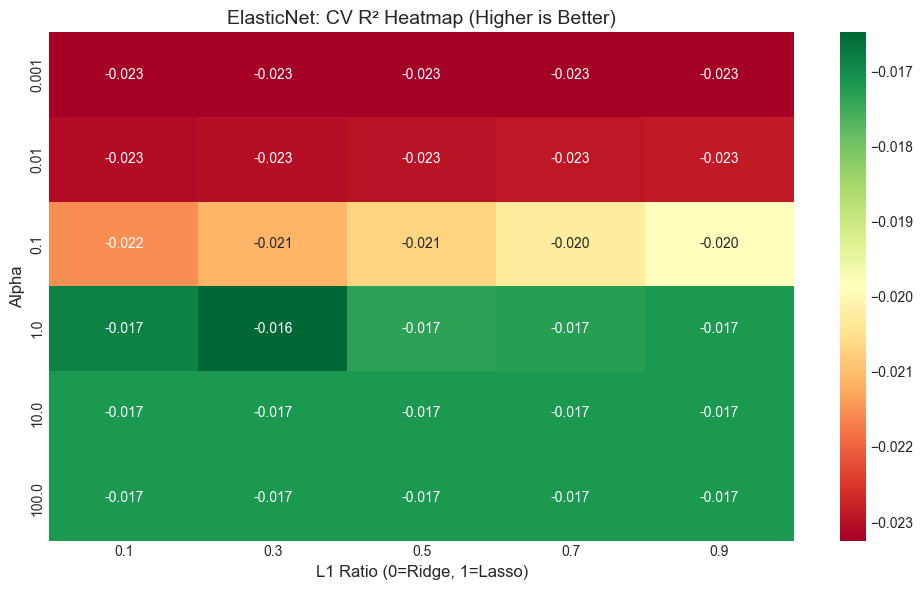

Figure saved to ../output/penalizedlinreg-outputs/elasticnet_cv_heatmap.png


In [95]:
# Visualize ElasticNet CV results as heatmap
elasticnet_results = pd.DataFrame(elasticnet_grid_search.cv_results_)

# Reshape for heatmap
pivot_data = elasticnet_results.pivot_table(
    values='mean_test_score',
    index='param_elasticnet__alpha',
    columns='param_elasticnet__l1_ratio'
)

fig, ax = plt.subplots(figsize=(10, 6))
sns.heatmap(pivot_data, annot=True, fmt='.3f', cmap='RdYlGn', ax=ax)  # RdYlGn (green=high=good for R²)
ax.set_xlabel('L1 Ratio (0=Ridge, 1=Lasso)', fontsize=12)
ax.set_ylabel('Alpha', fontsize=12)
ax.set_title('ElasticNet: CV R² Heatmap (Higher is Better)', fontsize=14)
plt.tight_layout()
plt.savefig(f'{OUTPUT_DIR}/elasticnet_cv_heatmap.png', dpi=150)
plt.show()

print(f"Figure saved to {OUTPUT_DIR}/elasticnet_cv_heatmap.png")


## 7. Model Comparison

Now we compare all three penalized regression models using multiple metrics computed via cross-validation.


In [96]:
# Compute multiple metrics for each best model using cross-validation
def evaluate_model_cv(model, X, y, cv, model_name):
    """Evaluate model using multiple metrics via cross-validation."""
    # Get cross-validated predictions
    y_pred_cv = cross_val_predict(model, X, y, cv=cv)
    
    # Calculate metrics
    mse = mean_squared_error(y, y_pred_cv)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y, y_pred_cv)
    r2 = r2_score(y, y_pred_cv)
    
    return {
        'Model': model_name,
        'R² Score': r2,
        'MSE': mse,
        'RMSE': rmse,
        'MAE': mae
    }

# Evaluate all models
results = []
results.append(evaluate_model_cv(ridge_grid_search.best_estimator_, X_train, y_train, cv, 'Ridge'))
results.append(evaluate_model_cv(lasso_grid_search.best_estimator_, X_train, y_train, cv, 'Lasso'))
results.append(evaluate_model_cv(elasticnet_grid_search.best_estimator_, X_train, y_train, cv, 'ElasticNet'))

# Create comparison dataframe
comparison_df = pd.DataFrame(results)
comparison_df = comparison_df.set_index('Model')

print("PENALIZED LINEAR REGRESSION - CROSS-VALIDATION RESULTS")
display(comparison_df.round(4))


PENALIZED LINEAR REGRESSION - CROSS-VALIDATION RESULTS


,R² Score,MSE,RMSE,MAE
Model,,,,
Ridge,-0.0059,74.2381,8.6162,7.4921
Lasso,-0.0060,74.2444,8.6165,7.4886
ElasticNet,-0.0054,74.1991,8.6139,7.4899


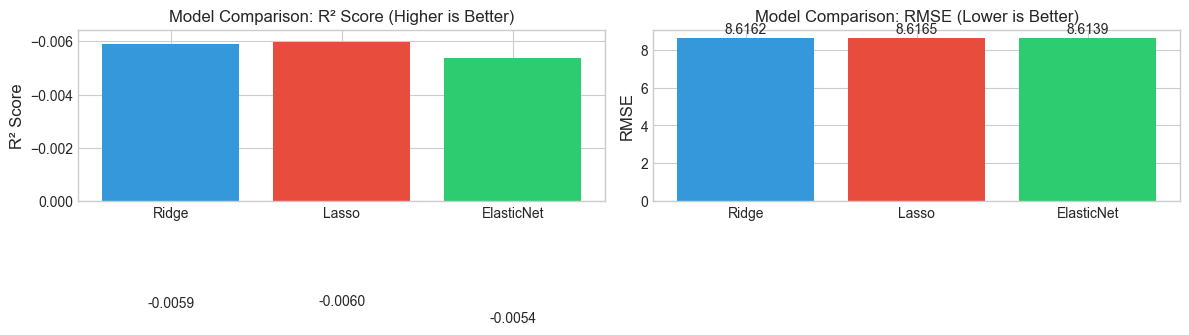

Figure saved to ../output/penalizedlinreg-outputs/penalized_regression_comparison.png


In [97]:
# Visualize model comparison
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Plot 1: R² comparison
ax1 = axes[0]
colors = ['#3498db', '#e74c3c', '#2ecc71']
bars1 = ax1.bar(comparison_df.index, comparison_df['R² Score'], color=colors)
ax1.set_ylabel('R² Score', fontsize=12)
ax1.set_title('Model Comparison: R² Score (Higher is Better)', fontsize=12)
ax1.set_ylim(0, max(comparison_df['R² Score']) * 1.2)
for bar, val in zip(bars1, comparison_df['R² Score']):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
             f'{val:.4f}', ha='center', va='bottom', fontsize=10)

# Plot 2: RMSE comparison
ax2 = axes[1]
bars2 = ax2.bar(comparison_df.index, comparison_df['RMSE'], color=colors)
ax2.set_ylabel('RMSE', fontsize=12)
ax2.set_title('Model Comparison: RMSE (Lower is Better)', fontsize=12)
for bar, val in zip(bars2, comparison_df['RMSE']):
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1, 
             f'{val:.4f}', ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.savefig(f'{OUTPUT_DIR}/penalized_regression_comparison.png', dpi=150)
plt.show()

print(f"Figure saved to {OUTPUT_DIR}/penalized_regression_comparison.png")


## 8. Best Model Selection

Based on the cross-validation results, we select the best performing penalized regression model.


In [98]:
# Select best model based on highest R²
best_model_name = comparison_df['R² Score'].idxmax()
best_r2 = comparison_df.loc[best_model_name, 'R² Score']
best_rmse = comparison_df.loc[best_model_name, 'RMSE']

# Get the corresponding grid search object
model_mapping = {
    'Ridge': ridge_grid_search,
    'Lasso': lasso_grid_search,
    'ElasticNet': elasticnet_grid_search
}

best_grid_search = model_mapping[best_model_name]
best_model = best_grid_search.best_estimator_

print("BEST PENALIZED REGRESSION MODEL")
print(f"\nModel: {best_model_name}")
print(f"\nOptimal Hyperparameters:")
for param, value in best_grid_search.best_params_.items():
    print(f"  - {param.split('__')[1]}: {value}")
print(f"\nCross-Validation Performance:")
print(f"  - R² Score: {best_r2:.4f}")
print(f"  - RMSE: {best_rmse:.4f}")
print(f"  - MSE: {comparison_df.loc[best_model_name, 'MSE']:.4f}")
print(f"  - MAE: {comparison_df.loc[best_model_name, 'MAE']:.4f}")


BEST PENALIZED REGRESSION MODEL

Model: ElasticNet

Optimal Hyperparameters:
  - alpha: 1
  - l1_ratio: 0.3

Cross-Validation Performance:
  - R² Score: -0.0054
  - RMSE: 8.6139
  - MSE: 74.1991
  - MAE: 7.4899


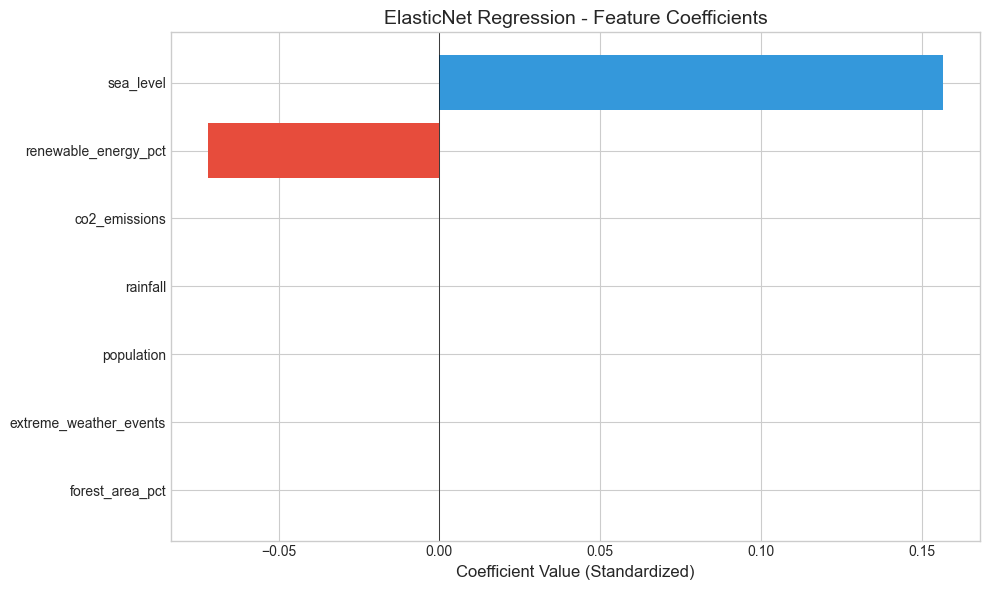


Figure saved to ../output/penalizedlinreg-outputs/best_model_coefficients.png

Coefficient Interpretation (standardized features):
  sea_level: +0.1567 (1 SD increase → temp increases)
  renewable_energy_pct: -0.0720 (1 SD increase → temp decreases)
  co2_emissions: +0.0000 (1 SD increase → temp decreases)
  rainfall: +0.0000 (1 SD increase → temp decreases)
  population: -0.0000 (1 SD increase → temp decreases)
  extreme_weather_events: +0.0000 (1 SD increase → temp decreases)
  forest_area_pct: -0.0000 (1 SD increase → temp decreases)


In [99]:
# Display coefficients of the best model
# Get the regressor from the pipeline
regressor_name = best_model_name.lower()
regressor = best_model.named_steps[regressor_name]

coef_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Coefficient': regressor.coef_
}).sort_values('Coefficient', key=abs, ascending=False)

# Plot coefficients
fig, ax = plt.subplots(figsize=(10, 6))
colors = ['#e74c3c' if c < 0 else '#3498db' for c in coef_df['Coefficient']]
bars = ax.barh(coef_df['Feature'], coef_df['Coefficient'], color=colors)
ax.axvline(x=0, color='black', linewidth=0.5)
ax.set_xlabel('Coefficient Value (Standardized)', fontsize=12)
ax.set_title(f'{best_model_name} Regression - Feature Coefficients', fontsize=14)
ax.invert_yaxis()
plt.tight_layout()
plt.savefig(f'{OUTPUT_DIR}/best_model_coefficients.png', dpi=150)
plt.show()

print(f"\nFigure saved to {OUTPUT_DIR}/best_model_coefficients.png")
print("\nCoefficient Interpretation (standardized features):")
for _, row in coef_df.iterrows():
    direction = "increases" if row['Coefficient'] > 0 else "decreases"
    print(f"  {row['Feature']}: {row['Coefficient']:+.4f} (1 SD increase → temp {direction})")


In [100]:
# Final summary table with all hyperparameters tested
print("COMPLETE HYPERPARAMETER SUMMARY")

print("\nRIDGE REGRESSION")
print(f"   Alpha values tested: {ridge_param_grid['ridge__alpha']}")
print(f"   Best alpha: {ridge_grid_search.best_params_['ridge__alpha']}")

print("\nLASSO REGRESSION")  
print(f"   Alpha values tested: {lasso_param_grid['lasso__alpha']}")
print(f"   Best alpha: {lasso_grid_search.best_params_['lasso__alpha']}")

print("\nELASTICNET REGRESSION")
print(f"   Alpha values tested: {elasticnet_param_grid['elasticnet__alpha']}")
print(f"   L1_ratio values tested: {elasticnet_param_grid['elasticnet__l1_ratio']}")
print(f"   Best alpha: {elasticnet_grid_search.best_params_['elasticnet__alpha']}")
print(f"   Best l1_ratio: {elasticnet_grid_search.best_params_['elasticnet__l1_ratio']}")

print("/nFINAL CV RESULTS TABLE")
display(comparison_df.round(4))

print("\nBest Penalized Regression Model:", best_model_name)
print(f"CV R² Score: {best_r2:.4f}")
# print(f"CV RMSE: {best_rmse:.4f}")


COMPLETE HYPERPARAMETER SUMMARY

RIDGE REGRESSION
   Alpha values tested: [0.001, 0.01, 0.1, 1, 10, 100, 1000]
   Best alpha: 1000

LASSO REGRESSION
   Alpha values tested: [0.001, 0.01, 0.1, 1, 10, 100, 1000]
   Best alpha: 1

ELASTICNET REGRESSION
   Alpha values tested: [0.001, 0.01, 0.1, 1, 10, 100]
   L1_ratio values tested: [0.1, 0.3, 0.5, 0.7, 0.9]
   Best alpha: 1
   Best l1_ratio: 0.3
/nFINAL CV RESULTS TABLE


,R² Score,MSE,RMSE,MAE
Model,,,,
Ridge,-0.0059,74.2381,8.6162,7.4921
Lasso,-0.0060,74.2444,8.6165,7.4886
ElasticNet,-0.0054,74.1991,8.6139,7.4899



Best Penalized Regression Model: ElasticNet
CV R² Score: -0.0054


In [101]:
# Save CV results to CSV
results_path = f'{OUTPUT_DIR}/cv_results_summary.csv'
comparison_df.to_csv(results_path)
print(f"CV results saved to: {results_path}")


CV results saved to: ../output/penalizedlinreg-outputs/cv_results_summary.csv
